In [2]:
import dask as da
from dask import array
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import h5py
import avul
import importlib
from scipy import ndimage
import scipy.misc
import skimage.measure
import rasterio
import csv
from multiprocessing.pool import ThreadPool
from skimage.measure import block_reduce
from skimage.measure import regionprops

In [3]:
#this is a development line used to reload avul.py after changes made 
importlib.reload(avul)

<module 'avul' from '/home/dylanblee/GlobalAvulsion/Code/avul.py'>

## Run active level analysis



In [8]:
#this loads your selection into memory
Im = Im.astype('uint8') #convert to unsigned int 8 to save space
Im = Im.compute()

#testing array
#testIm = Im[0:35,0:900,0:900]
#testIm = testIm.rechunk((-1,300,300))

In [9]:
#Binarize the image. Only run this once
Im = avulHPC.YearBinarize(Im)

In [10]:
#make sure image actually binarized 1
np.max(Im)

1

In [12]:
#get windows for rolling window analysis
strideparams = [60,365] #1st value is step size, 2nd value is window size
WinShape = Im.shape[1:3]
Subwins = avul.GetSubWins(Winshape,strideparams)
ZlevImShape = SubWins.shape[0:2]
#now iterate over sub-windows to build up image after taking the median at each window
SearIm = np.zeros(ZlevImShape)
ActLevIm = np.zeros(ZlevImShape)

In [13]:
#make sure your subwin shapes are an even divisor of your main image size
print((Im.shape[1] - xsize + 1) / ystep)
print((Im.shape[2] - ysize + 1) / xstep)

267.0
267.0


In [ ]:
#current analysis almost done when you hit near 555000
from IPython.core.debugger import set_trace
for x in range(np.max(ZlevFlatIn)+1):
    print(x)
    curSubWinInd = np.unravel_index(x,ZlevImShape)
    #get x and y range
    flRanMax = np.max(SubWins[curSubWinInd])
    flRanMin = np.min(SubWins[curSubWinInd])
    RangesMaxMin = [np.unravel_index(flRanMax,WinShape),np.unravel_index(flRanMin,WinShape)]
    SubIm = Im[:,RangesMaxMin[1][0]:RangesMaxMin[0][0]+1,RangesMaxMin[1][1]:RangesMaxMin[0][1]+1]
    SubMask = mask[RangesMaxMin[1][0]:RangesMaxMin[0][0]+1,RangesMaxMin[1][1]:RangesMaxMin[0][1]+1]
    #Query for all points within this range
    #set_trace()
    actRes = avulHPC.getvals(SubIm,SubMask,5,1) #set last argument to 1 if feeding in binary images!
    #print(pixval)
    SearIm[curSubWinInd] = actRes[1]
    ActLevIm[curSubWinInd] = actRes[0]

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [ ]:
#np.savez('DeepWaterMasked365PxAltiPlanoStride60',SearIm = SearIm, ActLevIm = ActLevIm)

## Analyze and visualize Ai map

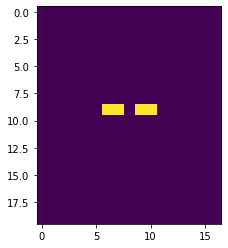

In [14]:
%matplotlib notebook
#Masked300PxAltiPlanoStride30VER2.npz is the one you used for the final analysis in the 1st paper.
#data = np.load('./GlobalAvulsionData/TestRegionResults/Masked300PxAltiPlanoStride30VER2.npz')
#DeepWaterAndManualMasked365PxAltiPlanoStride60.npz is the one you used for the 2nd paper
data = np.load('./DeepWaterAndManualMasked365PxAltiPlanoStride60.npz')
ActLevIm = data['ActLevIm']
CutActLevIm = ActLevIm * (ActLevIm >= 12)
plt.imshow(CutActLevIm[180:200,250:285])
#plt.colorbar()
#plt.savefig("AiMapZoomedIn.png",dpi=350)

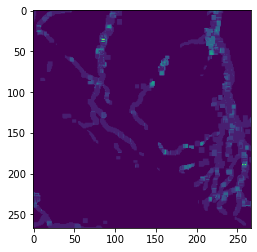

In [15]:
CutActLevIm = ActLevIm * (ActLevIm >= 12)
plt.imshow(ActLevIm)

In [17]:
#take output from last cell and get transform for cropped image so you can get centers of regions
#the bounds of the cropped image are taken from the bounds obtained in the "CreateOnDiskDataset" notebook
left = -68.91852401882868
bottom = -17.576032607204688 
right = -64.50312473432442
top = -13.160633322700418
NewTran = rasterio.transform.from_bounds(left, bottom, right, top, 16384, 16384)

In [ ]:
from IPython.core.debugger import set_trace
from PIL import Image
#Write video of all the areas that have greater than or equal to a certain active level
#Can then watch this video for different sections to look for cutoffs and avulsions in the active level 1 regions
MaxActLevThresh = 12
ActLevThresh = 2
CutActLevIm = ActLevIm * (ActLevIm >= ActLevThresh)
LabCutIm,tra = ndimage.measurements.label(CutActLevIm,structure=np.ones((3,3)))
labels = np.unique(LabCutIm[np.where(LabCutIm)])
CurLevRng = []
CurLevPts = []
total_number_of_frames = 34
#empty array of region id's and latitude's and longitude's. Right now only write for active level 2
ActLevRegLocs = []
AllRegAreas = [{},{},{},{},{},{},{},{},{},{},{},{}]
#there needs to be the same number of active levels as there are areas
for y in range(labels.size):
    #initialize ghetto way to turn 3d numpy array into list of 2d arrays. Fix this when have time/internet.
    allFrames = []
    print("current label")
    print(y)
    #Binary 
    #set_trace()
    CurLabIm = LabCutIm * (LabCutIm == labels[y])
    CurLabIm[CurLabIm == np.max(CurLabIm)] = 1
    CurRegActIm = ActLevIm * CurLabIm
    
    #reset ActLevThresh for next region
    ActLevThresh = 2
    while CurRegActIm.any():
        #plt.imshow(CurLabIm)
        #for this analysis need to cut out bounding box to get all points in region      
        props = regionprops(CurLabIm.astype('int32'))
        maxLoc = tuple(np.subtract(props[0].bbox[2:4],1))
        minLoc = tuple(props[0].bbox[0:2])
        flRanMax = np.max(SubWins[maxLoc])
        flRanMin = np.min(SubWins[minLoc])
        RangesMaxMin = [np.unravel_index(flRanMax,WinShape),np.unravel_index(flRanMin,WinShape)]
        SubIm = Im[:,RangesMaxMin[1][0]:RangesMaxMin[0][0]+1,RangesMaxMin[1][1]:RangesMaxMin[0][1]+1].astype('uint8')
        #get center of region on the inside the actual surface water image
        #set_trace()
        regcent = (np.round(RangesMaxMin[1][0]+(SubIm.shape[1]/2)),np.round(RangesMaxMin[1][1]+(SubIm.shape[2]/2)))
        
        #get real world location
        longlat = rasterio.transform.xy(NewTran, regcent[0], regcent[1], offset='center')

        SubMask = mask[RangesMaxMin[1][0]:RangesMaxMin[0][0]+1,RangesMaxMin[1][1]:RangesMaxMin[0][1]+1].astype('uint8')
        #GetReg returns the fluvial components in the region 
        #set_trace()
        ComIm = GetReg(SubIm,SubMask)

        RegDim = ComIm.shape

        #write each layer in the image as a seperate image so you can view as a video in imagej
        for x in range(ComIm.shape[0]):
            fr = ComIm[x,:,:]
            allFrames.append(fr)

        # Now we can do the plotting!
        all_data = allFrames
        fig, ax = plt.subplots(1, figsize=(4, 4))
        # Remove a bunch of stuff to make sure we only 'see' the actual imshow
        # Stretch to fit the whole plane
        fig.subplots_adjust(0, 0, 1, 1)
        # Remove bounding line
        ax.axis("off")
        # Initialise our plot. Make sure you set vmin and vmax to the active level range!
        image = ax.imshow(all_data[0], vmin=0, vmax=1)
        animation = FuncAnimation(fig,animate,np.arange(total_number_of_frames),fargs=[],interval=1000 / 5)
        # Try to set the DPI to the actual number of pixels you're plotting
        #save line for saving on local computer
        #animation.save("/home/dylan/GlobalAvulsion/GlobalAvulsionData/TestRegionResults/AltiPlanocornerActLev"+ str(ActLevThresh) + 'Reg'+ str(y).zfill(2)+".mp4", dpi=512)
        #gcloud save line
        animation.save("./ActLev"+ str(ActLevThresh) + '/' + 'Reg'+ str(y).zfill(3)+"ActLev"+str(ActLevThresh)+
                       "row"+str(maxLoc[0])+"col"+str(maxLoc[1])+".avi", dpi=512)
        
        #append the region information to a list containing the region id + lat and long of that region
        #if ActLevThresh == 2:
        #    ActLevRegLocs.append('Reg'+ str(y).zfill(3)+"ActLev"+str(ActLevThresh) + " Latitude:" + str(longlat[1]) + " Longitude:" + str(longlat[0]))
        
        #write
        AllRegAreas[ActLevThresh-1][y] = RegDim[1]*RegDim[2]
        #raise threshold for next iteration of this region
        ActLevThresh = ActLevThresh + 1
        #set_trace()
        CurRegActIm = CurRegActIm * (CurRegActIm >= ActLevThresh)
        #print("maximum active level for region")
        #print(np.max(CurRegActIm))
        BinCurRegActIm = CurRegActIm.copy()
        BinCurRegActIm[BinCurRegActIm >= 2] = 1
        CurLabIm = BinCurRegActIm
        

current label
0
current label
1
current label
2
current label
3
current label
4
current label
5
current label
6
current label
7
current label
8


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:62: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


current label
9
current label
10
current label
11
current label
12
current label
13
current label
14
current label
15
current label
16
current label
17
current label
18
current label
19
current label
20
current label
21
current label
22
current label
23
current label
24
current label
25
current label
26
current label
27
current label
28
current label
29
current label
30
current label
31
current label
32
current label
33
current label
34
current label
35
current label
36
current label
37
current label
38
current label
39
current label
40
current label
41
current label
42
current label
43
current label
44
current label
45
current label
46
current label
47
current label
48
current label
49
current label
50
current label
51
current label
52
current label
53
current label
54
current label
55
current label
56
current label
57
current label
58
current label
59
current label
60


In [40]:
CutActLevIm = ActLevIm * (ActLevIm >= ActLevThresh)
LabCutIm,tra = ndimage.measurements.label(CutActLevIm,structure=np.ones((3,3)))
labels = np.unique(LabCutIm[np.where(LabCutIm)])

In [77]:
#code snippet to save the areas of all the regions you've recorded to a seperate csv file for each active level
for x in range(12):
    # define a dictionary with key value pairs
    CurAreadict = AllRegAreas[x]
    # open file for writing, "w" is writing
    myfile = open("ActLev" + str(x+1) + "areas.csv",'w')
    w = csv.writer(myfile)
    # loop over dictionary keys and values
    for key, val in CurAreadict.items():
        # write every key and value to file. Convert to units of km^2
        w.writerow([key, val*0.0009])
        myfile.flush()

In [79]:
#this code snippet doesn't work in google cloud but it is self contained so can plot onsite or using colabs I think. Data is entered manually and derived from Riley's spreadsheet
%matplotlib notebook
#plot the final results of the region analysis.
fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(12.5,4))
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
ax1.scatter(np.asarray([12,11,10,9,8,7,6,5,4,3,2]),np.asarray([1,1,1,1,1,.75,.73,.72,.75,.72,.58]))
ax1.set_xlim(12, 1)
ax1.set_xlabel('Threshold $A_i$',fontsize=14)
ax1.set_ylabel('fraction of regions containing event',fontsize=14)
ax1.tick_params(axis='both', labelsize=12)

ax2.scatter(np.asarray([12,11,10,9,8,7,6,5,4,3,2]),np.asarray([199,358,378,557,826,3397,4668,10516,18406,28955,54569]))
ax2.set_xlim(12, 1)
ax2.set_xlabel('Threshold $A_i$',fontsize=14)
ax2.set_ylabel('Total area of regions ($km^2$)',fontsize=14)
ax2.tick_params(axis='both', labelsize=12)

#plot event density per km^2 for the different active levels
ax3.scatter(np.asarray([12,11,10,9,8,7,6,5,4,3,2]),np.asarray([.015,.02,.019,.016,.017,.009,.008,.01,.007,.005,.005])*100)
ax3.set_xlabel('Threshold $A_i$',fontsize=14)
ax3.set_ylabel('events per 100 $km^2$',fontsize=14)
ax3.set_xlim(12, 1)
ax3.tick_params(axis='both', labelsize=12)

plt.tight_layout()
plt.savefig("RegionResultPlots.png",dpi=350)

<IPython.core.display.Javascript object>

RuntimeError: Failed to process string with tex because latex could not be found

<IPython.core.display.Javascript object>


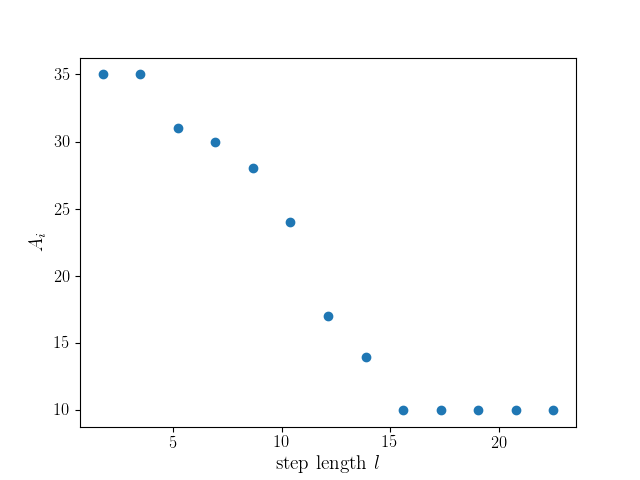

In [34]:
#plot an example of #of endtimes stabalizing as you increase the step length l. This is currently figure _
stepL = np.asarray([1.732,3.464,5.196,6.928,8.660,10.392,12.124,13.856,15.588,17.320,19.052,20.784,22.516])
Ai = np.asarray([35,35,31,30,28,24,17,14,10,10,10,10,10])
plt.scatter(stepL,Ai)
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.ylabel('$A_i$',fontsize=14)
plt.xlabel('step length $l$',fontsize=14)
plt.tick_params(axis='both', labelsize=12)
plt.savefig("AiStablizingPlot.png",dpi=350)

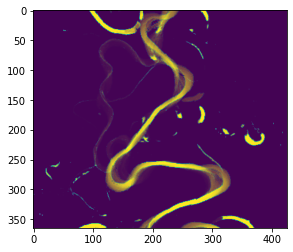

In [46]:
#code snippet for figure 8 panel c
%matplotlib inline
for x in range(35):
    colIm = ComIm[x]
    colIm[colIm==1] = x
    plt.imshow(SubIm[x],alpha=.1,cmap='viridis')
plt.savefig("Figure8PanelC.png",dpi=350)

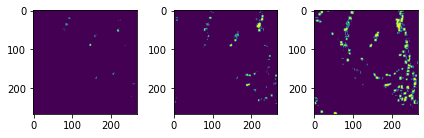

In [10]:
# code for figure 9
%matplotlib inline
CutActLevIm6 = ActLevIm * (ActLevIm >= 6)
CutActLevIm4 = ActLevIm * (ActLevIm >= 4)
CutActLevIm2 = ActLevIm * (ActLevIm >= 2)
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
ax1.imshow((CutActLevIm6 > 0).astype(int))
ax2.imshow((CutActLevIm4 > 0).astype(int))
ax3.imshow((CutActLevIm2 > 0).astype(int))
plt.tight_layout()
plt.savefig("Fig9PlotsUnlabeled.png",dpi=350)


#if you want to use a colorbar
#subplot(1, 3, 1)
#plt.imshow((LabCutIm > 0).astype(int),vmin=0, vmax=1, cmap='viridis', aspect='auto')
#plt.colorbar()